In [25]:
#Gerando os arquivos para cada caso mas omitindo a cada run

#Bibliotecas:
import numpy as np
import pandas as pd
from qutip import *
import csv 
import latex

import matplotlib.pyplot as plt 
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": "18",
    "font.serif": ["Times New Roman"]})
import matplotlib
matplotlib.rc('xtick', labelsize=18) 
matplotlib.rc('ytick', labelsize=18)
matplotlib.rc('legend', fontsize=14) 
import matplotlib.gridspec as gridspec
from palettable.colorbrewer.qualitative import Set1_5

qutip.settings.num_cpus

8

In [26]:
def mean_number_photons(delta,input_list,times,psi0):

    """
    This function handles the time evolution and returns the mean number 
    of photons for each value of detuning.
    """
    
    Nat = input_list[0]
    N = input_list[1] 
    kappa = input_list[2]
    g = input_list[3]
    EM = input_list[4]
    Oc = input_list[5]
    norm = input_list[6]
    
    G31 = input_list[7]
    G32 = input_list[8]
    D1 = input_list[9]
    D2 = input_list[10]
    
    #field operator
    op_list = []
    for m in range(Nat+1):
        op_list.append(qeye(3))
    op_list[0] = destroy(N)
    a = tensor(op_list) #muda conforme o numero de atomos
    
    #atomic operators
    S11_list = []
    S22_list = []
    S33_list = []
    S13_list = []
    S23_list = []
    
    for n in range(Nat):
        op_list = []
        for m in range(Nat+1):
            op_list.append(qeye(3))

        op_list[0] = qeye(N)
        
        op_list[n+1] = basis(3,0)*basis(3,0).dag()
        S11_list.append(tensor(op_list))

        op_list[n+1] = basis(3,1)*basis(3,1).dag()
        S22_list.append(tensor(op_list))

        op_list[n+1] = basis(3,2)*basis(3,2).dag()
        S33_list.append(tensor(op_list))
        
        op_list[n+1] = basis(3,0)*basis(3,2).dag()
        S13_list.append(tensor(op_list))
        
        op_list[n+1] = basis(3,1)*basis(3,2).dag()
        S23_list.append(tensor(op_list))        
       
    #total atomic operators
    S11 = 0
    S22 = 0
    S33 = 0
    S13 = 0
    S23 = 0
    
    for n in range(Nat):
        S11 = S11 + S11_list[n]
        S22 = S22 + S22_list[n]
        S33 = S33 + S33_list[n]
        S13 = S13 + S13_list[n]
        S23 = S23 + S23_list[n]

    #colapse Operators
    C = np.sqrt(kappa)*a   #cavity  
    C31_list = []
    C32_list = []
    
    for n in range(Nat):
        C31_list.append(np.sqrt(G31)*S13_list[n])
        C32_list.append(np.sqrt(G32)*S23_list[n])
    
    Clist = [C] + C31_list + C32_list

    Ht = D1*S33 + (D1-D2)*S22 + delta*S11 - delta*a.dag()*a + (g*a*S13.dag() + Oc*S23.dag() + EM*a + g*a.dag()*S13 + Oc*S23 + EM*a.dag())
        

    # master equation solver
    #data = mesolve(Ht, psi0, times, Clist, [a.dag() * a])
    #nm_at = data.expect[0]/norm
    #nm_a = np.mean(nm_at[-100:])
        
    # monte carlo solver
    #opt = Options(ntraj=2560,num_cpus=8)
    #options={"progress_bar": False, "ntraj": 2560}#, "num_cpus": 8}
    #data = mcsolve(Ht, psi0, times, Clist, [a.dag() * a], progress_bar=False, ntraj=80)#,num_cpus=8)
    #nm_at = data.expect[0]/norm
    #nm_a = np.mean(nm_at[-100:])
    
    #print("%f,%f" %(delta,nm_a)) 

    #steady state method (demands a high amount of memory as we increase the system's dimension)
    rho_a = steadystate(Ht, Clist, method='direct', use_precond=True, use_rcm=True, maxiter=1000, tol=1e-12)
    nm_a = expect(a.dag()*a, rho_a)/norm  # expectation value of nm -> normalized

    return nm_a

In [27]:
if __name__ == '__main__':   
    
    kappa = 1.0 #cavity mode dissipation rate
    Oc = 1.0*kappa
    Nat = 1    
    N = 6 #Fock space dimension
    g = (1.0/np.sqrt(Nat))*kappa #atom-field coupling strenght
    EM = np.sqrt(0.1)*kappa #pump field strength
    norm = 4*(EM/(kappa))**2 #normalization
    #decay rates
    G31 = 0.5*kappa  #atom
    G32 = 0.5*kappa  #atom
    #detunings
    D1 = 0.0
    D2 = 0.0
    DeltaP_list = np.linspace(-5,5,301)*kappa
        
    times = np.linspace(0.0, 2100, 1050) #evolution time list
    aux_list = []
    for m in range(Nat+1):
        aux_list.append(basis(3,1))
    aux_list[0] = basis(N,0)
    psi0 = tensor(aux_list)
    
    NMa = []

    for i in range(len(DeltaP_list)):
        
        delta = DeltaP_list[i]
        input_list = [Nat,N,kappa,g,EM,Oc,norm,G31,G32,D1,D2]
        NMa.append(mean_number_photons(delta, input_list, times, psi0))
        print(delta)

    output_data = np.vstack((DeltaP_list, NMa))   # join Oc and expt data
    file_data_store('CEIT_quantum_Nat1_g1_ep01_Oc1.csv', output_data.T, numtype="real", numformat="decimal", sep= ",") 
    

/home/solakerino/miniconda3/lib/python3.12/site-packages/qutip/solver/steadystate.py:229: RuntimeWarning: Only CSR matrices can be permuted.
  warn("Only CSR matrices can be permuted.", RuntimeWarning)
/home/solakerino/miniconda3/lib/python3.12/site-packages/qutip/solver/steadystate.py:234: RuntimeWarning: Only sparse solver use preconditioners.
  warn("Only sparse solver use preconditioners.", RuntimeWarning)


-5.0
-4.966666666666667
-4.933333333333334
-4.9
-4.866666666666666
-4.833333333333333
-4.8
-4.766666666666667
-4.733333333333333
-4.7
-4.666666666666667
-4.633333333333334
-4.6
-4.566666666666666
-4.533333333333333
-4.5
-4.466666666666667
-4.433333333333334
-4.4
-4.366666666666667
-4.333333333333333
-4.3
-4.266666666666667
-4.233333333333333
-4.2
-4.166666666666667
-4.133333333333333
-4.1
-4.066666666666666
-4.033333333333333
-4.0
-3.966666666666667
-3.9333333333333336
-3.9
-3.8666666666666667
-3.833333333333333
-3.8
-3.7666666666666666
-3.7333333333333334
-3.7
-3.666666666666667
-3.6333333333333333
-3.6
-3.5666666666666664
-3.533333333333333
-3.5
-3.466666666666667
-3.4333333333333336
-3.4
-3.3666666666666667
-3.333333333333333
-3.3
-3.2666666666666666
-3.2333333333333334
-3.2
-3.166666666666667
-3.1333333333333333
-3.1
-3.0666666666666664
-3.033333333333333
-3.0
-2.966666666666667
-2.9333333333333336
-2.9
-2.8666666666666667
-2.8333333333333335
-2.8
-2.7666666666666666
-2.73333333333

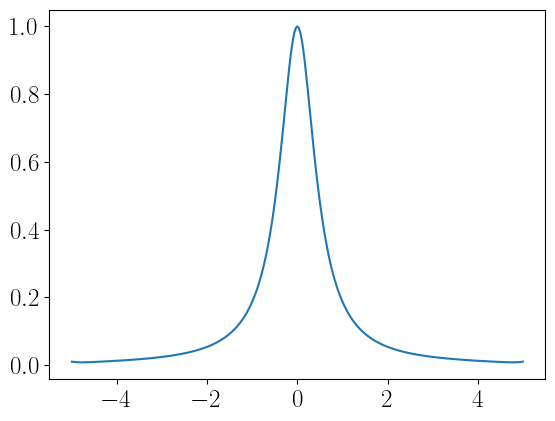

In [24]:
#pré-plot da etapa de geração de dados para a cavidade vazia
plt.plot(DeltaP_list,NMa)
plt.show()
#fig.savefig('photo.jpeg', format='jpeg', dpi=1200)

In [34]:
a = [1,2,3,4,5,6,7,8,9]

In [43]:
b = a[:len(a)]

In [44]:
b

[1, 2, 3, 4, 5, 6, 7, 8, 9]